In [1]:
# <a name="paso-0"></a> 🔧 PASO 0: Configurar rutas del sistema

"""
ALGORITMO GENÉTICO PARA ENRUTAMIENTO DE VEHÍCULOS (VRPTW)

Este es el PRIMER PASO. Ejecuta esta celda antes que cualquier otra.
Configura las rutas del sistema para que Python encuentre los módulos necesarios.
"""

import sys
import os

# Asegurar que estamos en el directorio correcto
os.chdir(r'C:\Users\sjaim\Metahuristica')
sys.path.insert(0, r'C:\Users\sjaim\Metahuristica')

print("="*80)
print(" " * 20 + "🚀 ALGORITMO GENÉTICO PARA ENRUTAMIENTO DE VEHÍCULOS")
print("="*80)
print("\n✅ PASO 0: SISTEMA CONFIGURADO")
print("-" * 80)
print(f"\n✓ Working directory: {os.getcwd()}")
print(f"✓ System path: {sys.path[0]}")
print(f"\n📌 Siguiente paso: Ejecuta la siguiente celda (Paso 1)")
print("-" * 80)

                    🚀 ALGORITMO GENÉTICO PARA ENRUTAMIENTO DE VEHÍCULOS

✅ PASO 0: SISTEMA CONFIGURADO
--------------------------------------------------------------------------------

✓ Working directory: C:\Users\sjaim\Metahuristica
✓ System path: C:\Users\sjaim\Metahuristica

📌 Siguiente paso: Ejecuta la siguiente celda (Paso 1)
--------------------------------------------------------------------------------


# 🎯 Algoritmo Genético para Enrutamiento de Vehículos (VRPTW)

## 📋 Tabla de Contenidos

| Paso | Sección | Descripción |
| :---: | :--- | :--- |
| 0️⃣ | **[Sistema](#paso-0)** | Configurar rutas y entorno |
| 1️⃣ | **[Librerías](#paso-1)** | Importar librerías necesarias |
| 2️⃣ | **[Datos](#paso-2)** | Cargar instancia del problema |
| 3️⃣ | **[Análisis](#paso-3)** | Examinar camiones y clientes |
| 4️⃣ | **[Operadores](#paso-4)** | Entender GA (Cruce, Mutación) |
| 5️⃣ | **[Población](#paso-5)** | Crear soluciones iniciales |
| 6️⃣ | **[Ejecución](#paso-6)** | Ejecutar Algoritmo Genético |
| 7️⃣ | **[Resultados](#paso-7)** | Mostrar mejor solución |
| 8️⃣ | **[Conclusiones](#paso-8)** | Comparar con benchmark |

---

## 🎓 ¿Qué es este notebook?

Este notebook implementa un **Algoritmo Genético (GA)** para resolver el **Problema de Enrutamiento de Vehículos con Restricciones de Tiempo (VRPTW)**:

**Objetivo:** Encontrar el mejor orden para visitar clientes con mínimo costo

| Aspecto | Descripción |
| :--- | :--- |
| **Qué optimizar** | Costo total (contratos + penalizaciones) |
| **Decisiones** | Asignar clientes a camiones + orden de visita |
| **Restricciones** | Ventanas de tiempo, capacidad, horarios |
| **Solución** | Rutas óptimas para cada vehículo |

---

## ⚙️ Cómo Usar Este Notebook

**Paso 1:** Ejecuta la celda **Paso 0** (arriba) para configurar

**Paso 2:** Luego ejecuta todas las celdas en orden (Paso 1 → Paso 8)

**Paso 3:** Si quieres otro archivo de datos, modifica en Paso 2:
```python
dat_file = 'instances/tu_archivo.dat'
```

**Paso 4:** El GA tardará 15-30 minutos en ejecutarse (es normal)

---

---

## 🚀 INSTRUCCIONES RÁPIDAS

**¿Primero vez?** Sigue estos pasos:

1. ✅ **Ejecuta la celda de ARRIBA** (Paso 0: Rutas del sistema)
2. 📦 **Ejecuta las celdas en orden** (Paso 1 → Paso 8)
3. ⏱️ **El GA tarda ~15-30 minutos** (Paso 7)
4. 📊 **Mira los resultados al final** (Pasos 7-8)

**Cambiar datos:**
- Paso 2: Modifica `dat_file = 'instances/tu_archivo.dat'`

**Ajustar GA:**
- Paso 5: Modifica `POPSIZE`, `GENS`, `ROUTE_PENALTY`

---

In [2]:
# <a name="paso-1"></a> 📦 PASO 1: Importar librerías necesarias

"""
Importamos todos los módulos necesarios para:
1. Cargar y procesar datos (data_loader)
2. Codificar/decodificar soluciones (encoding)
3. Evaluar soluciones (simulator)
4. Aplicar búsqueda local (ga_utils)
5. Visualizar resultados (matplotlib, pandas)
"""

from src.data_loader import parse_ampl_dat, build_instance
from src.encoding import (
    encode_routes, decode_vector, route_based_crossover, 
    swap_mutation, insert_mutation, tournament_selection
)
from src.simulator import evaluate_individual, schedule_muelles
from src.ga_utils import (
    local_search_on_routes, population_diversity, merge_routes_local_search
)

import pandas as pd
import numpy as np
import json
from copy import deepcopy
import random
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("✅ PASO 1: LIBRERÍAS IMPORTADAS")
print("="*80)

print("\n📚 Módulos cargados correctamente:")
print("  ├─ 📁 data_loader: Parsing de archivos .dat")
print("  ├─ 🧬 encoding: Codificación de soluciones y operadores GA")
print("  ├─ ⚙️ simulator: Evaluación de rutas (costo + penalizaciones)")
print("  ├─ 🔍 ga_utils: Búsqueda local y refinamiento")
print("  └─ 📊 Utilidades: pandas, numpy, matplotlib")

print(f"\n📌 Siguiente paso: Ejecuta el Paso 2 (Cargar datos)")
print("="*80)


✅ PASO 1: LIBRERÍAS IMPORTADAS

📚 Módulos cargados correctamente:
  ├─ 📁 data_loader: Parsing de archivos .dat
  ├─ 🧬 encoding: Codificación de soluciones y operadores GA
  ├─ ⚙️ simulator: Evaluación de rutas (costo + penalizaciones)
  ├─ 🔍 ga_utils: Búsqueda local y refinamiento
  └─ 📊 Utilidades: pandas, numpy, matplotlib

📌 Siguiente paso: Ejecuta el Paso 2 (Cargar datos)


---

## <a name="paso-2"></a> 📁 Paso 2: Cargar los Datos del Archivo .dat

El archivo `.dat` (formato AMPL) contiene la **descripción completa del problema**:

### Contenido del archivo `.dat`:
- **Camiones:** Capacidades, costos horarios, franjas de horario
- **Clientes:** Ubicación, demanda (entrega/recogida), ventanas de tiempo
- **Parámetros globales:** Costos de penalización, horarios, muelles disponibles

### 🔍 Cómo cambiar el archivo de datos:
Modifica la variable `dat_file` en la siguiente celda si tienes otro archivo `.dat` disponible.

In [5]:
# ⚙️ CONFIGURABLE: Cambiar esta ruta si tienes otro archivo .dat
dat_file = 'instances/sebas_3camiones_10clientes.dat'  

In [13]:
# Parsear y construir la instancia
parsed = parse_ampl_dat(dat_file)
inst = build_instance(parsed)

print("\n" + "="*80)
print("✅ PASO 2: INSTANCIA CARGADA DEL ARCHIVO")
print("="*80)

print(f"\n📄 Archivo: {dat_file}")
print(f"  ├─ Nodos totales: {inst.n_nodes()} (1 depósito + {inst.n_nodes()-1} clientes)")
print(f"  ├─ Camiones disponibles: {len(inst.trucks)}")
print(f"  ├─ Clientes a visitar: {len([c for c in inst.clients.values() if c.escliente == 1])}")
print(f"  └─ ✓ Estado: Listo para análisis")

print(f"\n📌 Siguiente paso: Ejecuta el Paso 3 (Analizar instancia)")
print("="*80)


✅ PASO 2: INSTANCIA CARGADA DEL ARCHIVO

📄 Archivo: instances/sebas_3camiones_10clientes.dat
  ├─ Nodos totales: 11 (1 depósito + 10 clientes)
  ├─ Camiones disponibles: 3
  ├─ Clientes a visitar: 10
  └─ ✓ Estado: Listo para análisis

📌 Siguiente paso: Ejecuta el Paso 3 (Analizar instancia)


---

## <a name="paso-3"></a> 🚚 Paso 3: Analizar la Instancia

Veamos los detalles de los camiones y clientes que tenemos que optimizar.

In [15]:
# 📊 Analizar parámetros del problema

print("\n" + "="*70)
print("✓ PASO 3: ANÁLISIS DE LA INSTANCIA")
print("="*70)

# Tabla de camiones
print("\n🚚 CAMIONES DISPONIBLES:")
print("-" * 70)
truck_data = []
for tid, truck in inst.trucks.items():
    tipo = "Por Hora" if truck.esHora else ("Franja 12h" if truck.esF12 else "Franja 6h")
    truck_data.append({
        'ID': tid,
        'Capacidad': f"{truck.Cap:.0f}",
        'Costo/Hora': f"${truck.CH:.1f}" if truck.esHora else "-",
        'Costo 6h': f"${truck.CF6:.1f}" if truck.esF6 else "-",
        'Costo 12h': f"${truck.CF12:.1f}" if truck.esF12 else "-",
        'Tipo': tipo
    })

df_trucks = pd.DataFrame(truck_data)
print(df_trucks.to_string(index=False))

# Tabla de clientes
print("\n\n👥 CLIENTES A VISITAR:")
print("-" * 70)
client_data = []
for cid, client in inst.clients.items():
    if client.escliente == 1:
        client_data.append({
            'ID': cid,
            'Entrega': f"{client.DemE:.1f}",
            'Recogida': f"{client.DemR:.1f}",
            'Tiempo Servicio': f"{client.TS:.2f}h",
            'Min Llegada': f"{client.MinDC:.1f}",
            'Max Llegada': f"{client.MaxDC:.1f}",
            'Crítico': '✓' if client.escritico == 1 else ' '
        })

df_clients = pd.DataFrame(client_data)
print(df_clients.to_string(index=False))

# Parámetros de penalización
print("\n\n⚙️ PARÁMETROS DE PENALIZACIÓN:")
print("-" * 70)
penalties = {
    'Llegar antes en cliente crítico': inst.params.get('pcmin_c', 10),
    'Llegar después en cliente crítico': inst.params.get('pcmax_c', 15),
    'Llegar antes en cliente no crítico': inst.params.get('pcmin_nc', 5),
    'Llegar después en cliente no crítico': inst.params.get('pcmax_nc', 8),
    'Regresar después de 18:00': inst.params.get('preg', 20),
    'Por HORA de espera': inst.params.get('pw', 1000),
}

for penalidad, valor in penalties.items():
    print(f"  • {penalidad}: {valor:,.0f} pts")


✓ PASO 3: ANÁLISIS DE LA INSTANCIA

🚚 CAMIONES DISPONIBLES:
----------------------------------------------------------------------
 ID Capacidad Costo/Hora Costo 6h Costo 12h       Tipo
  1        80          -        -    $537.0 Franja 12h
  2       137          -        -    $464.0 Franja 12h
  3       107     $128.0        -         -   Por Hora


👥 CLIENTES A VISITAR:
----------------------------------------------------------------------
 ID Entrega Recogida Tiempo Servicio Min Llegada Max Llegada Crítico
  1     6.0      3.0           0.31h        10.0        18.0       ✓
  2     7.0      6.0           0.26h         9.0        15.0       ✓
  3     9.0      0.0           0.24h        11.0        16.0        
  4     9.0      6.0           0.34h         8.0        14.0       ✓
  5     5.0      2.0           0.10h         6.0        14.0        
  6    14.0      2.0           0.32h        12.0        19.0       ✓
  7    18.0      4.0           0.26h         7.0        14.0        
 

---

## <a name="paso-4"></a> 🧬 Paso 4: Entender los Operadores Genéticos

Veamos cómo funciona el Algoritmo Genético con ejemplos didácticos.

In [16]:
# 📖 PASO 4: Entender la codificación de soluciones

print("\n" + "="*70)
print("✓ PASO 4: CODIFICACIÓN DE SOLUCIONES")
print("="*70)

print("\n🔢 ¿Cómo representamos una solución?")
print("-" * 70)
print("""
Una solución es un VECTOR donde:
  • Números = IDs de clientes a visitar
  • Ceros = Separadores entre rutas (uno por camión)
  
Ejemplo:
  Vector: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
  
  Interpretación (4 camiones):
    • Camión 1: Ruta [1, 5, 3]        (3 clientes)
    • Camión 2: Ruta [2, 8, 6]        (3 clientes)
    • Camión 3: Ruta [10, 9, 4, 7]    (4 clientes)
    • Camión 4: Ruta []               (vacío, no se usa)
""")

# Ejemplo visual
print("\n📝 Ejemplo de codificación:")
print("-" * 70)
vector_ejemplo = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"Vector: {vector_ejemplo}")
print(f"Rutas decodificadas: {decode_vector(vector_ejemplo)}")
print(f"\nCada ruta será evaluada en términos de:")
print(f"  • Tiempo total de la ruta")
print(f"  • Costo (contrato del camión)")
print(f"  • Penalizaciones (ventanas de tiempo, esperas)")


✓ PASO 4: CODIFICACIÓN DE SOLUCIONES

🔢 ¿Cómo representamos una solución?
----------------------------------------------------------------------

Una solución es un VECTOR donde:
  • Números = IDs de clientes a visitar
  • Ceros = Separadores entre rutas (uno por camión)

Ejemplo:
  Vector: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]

  Interpretación (4 camiones):
    • Camión 1: Ruta [1, 5, 3]        (3 clientes)
    • Camión 2: Ruta [2, 8, 6]        (3 clientes)
    • Camión 3: Ruta [10, 9, 4, 7]    (4 clientes)
    • Camión 4: Ruta []               (vacío, no se usa)


📝 Ejemplo de codificación:
----------------------------------------------------------------------
Vector: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
Rutas decodificadas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

Cada ruta será evaluada en términos de:
  • Tiempo total de la ruta
  • Costo (contrato del camión)
  • Penalizaciones (ventanas de tiempo, esperas)


---

### 🧬 Operadores Genéticos

El GA usa tres operadores principales para explorar el espacio de soluciones:

#### 1️⃣ **CRUCE (Crossover)** - Combinar dos soluciones
- Toma segmentos de dos padres y combina en un hijo
- Preserva la estructura (número de camiones)
- Busca heredar características buenas de ambos padres

#### 2️⃣ **MUTACIÓN** - Modificar una solución
- **SWAP:** Intercambia dos clientes de posición
- **INSERT:** Toma un cliente y lo inserta en otra posición
- Permite escapar de mínimos locales

#### 3️⃣ **BÚSQUEDA LOCAL** - Mejorar rutas
- Optimiza el orden de visita dentro de cada ruta
- Reduce tiempo de ruta y penalizaciones
- Se aplica con probabilidad adaptativa

In [17]:
# 🧬 Ejemplo 1: CRUCE (Route-Based Crossover - RBX)

print("\n" + "="*70)
print("OPERADOR 1: CRUCE (Route-Based Crossover)")
print("="*70)

padre_A = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
padre_B = [0, 4, 6, 3, 0, 2, 9, 8, 0, 1, 7, 10, 5, 0]

print(f"\n📍 Padre A: {padre_A}")
print(f"   Rutas: {decode_vector(padre_A)}")

print(f"\n📍 Padre B: {padre_B}")
print(f"   Rutas: {decode_vector(padre_B)}")

hijo = route_based_crossover(padre_A, padre_B)

print(f"\n👶 Hijo (RBX): {hijo}")
print(f"   Rutas: {decode_vector(hijo)}")

print("\n💡 ¿Qué pasó?")
print("   El hijo heredó rutas completas del Padre A y B")
print("   Esto mantiene la estructura del problema intacta")


OPERADOR 1: CRUCE (Route-Based Crossover)

📍 Padre A: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
   Rutas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

📍 Padre B: [0, 4, 6, 3, 0, 2, 9, 8, 0, 1, 7, 10, 5, 0]
   Rutas: [[4, 6, 3], [2, 9, 8], [1, 7, 10, 5]]

👶 Hijo (RBX): [0, 6, 3, 2, 0, 8, 1, 5, 0, 10, 9, 4, 7, 0]
   Rutas: [[6, 3, 2], [8, 1, 5], [10, 9, 4, 7]]

💡 ¿Qué pasó?
   El hijo heredó rutas completas del Padre A y B
   Esto mantiene la estructura del problema intacta


---

### 📚 Ejemplos de Operadores

In [18]:
# 🧬 Ejemplo 2: MUTACIÓN - SWAP (Intercambio)

print("\n" + "="*70)
print("OPERADOR 2A: MUTACIÓN SWAP (Intercambiar dos clientes)")
print("="*70)

original = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"\n📍 Vector original: {original}")
print(f"   Rutas: {decode_vector(original)}")

mutado = swap_mutation(original)
print(f"\n🔄 Vector mutado: {mutado}")
print(f"   Rutas: {decode_vector(mutado)}")

print("\n💡 ¿Qué pasó?")
print("   Se intercambiaron dos clientes de posición")
print("   Esto cambia el orden de visita (puede mejorar o empeorar)")
print("   La búsqueda local después corregirá el orden si es malo")


OPERADOR 2A: MUTACIÓN SWAP (Intercambiar dos clientes)

📍 Vector original: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
   Rutas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

🔄 Vector mutado: [0, 1, 5, 2, 3, 0, 8, 6, 10, 0, 9, 4, 7, 0]
   Rutas: [[1, 5, 2, 3], [8, 6, 10], [9, 4, 7]]

💡 ¿Qué pasó?
   Se intercambiaron dos clientes de posición
   Esto cambia el orden de visita (puede mejorar o empeorar)
   La búsqueda local después corregirá el orden si es malo


---

### 🔄 Mutación INSERT

In [19]:
# 🧬 Ejemplo 3: MUTACIÓN - INSERT (Reinsertar cliente)

print("\n" + "="*70)
print("OPERADOR 2B: MUTACIÓN INSERT (Mover cliente a otra posición)")
print("="*70)

original = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"\n📍 Vector original: {original}")
print(f"   Rutas: {decode_vector(original)}")

mutado = insert_mutation(original)
print(f"\n🔄 Vector mutado: {mutado}")
print(f"   Rutas: {decode_vector(mutado)}")

print("\n💡 ¿Qué pasó?")
print("   Se tomó un cliente y se insertó en otra posición")
print("   Puede cambiar un cliente entre rutas o solo reordenar")
print("   Permite explorar asignaciones completamente distintas")


OPERADOR 2B: MUTACIÓN INSERT (Mover cliente a otra posición)

📍 Vector original: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
   Rutas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

🔄 Vector mutado: [0, 1, 5, 3, 2, 0, 6, 8, 10, 0, 9, 4, 7, 0]
   Rutas: [[1, 5, 3, 2], [6, 8, 10], [9, 4, 7]]

💡 ¿Qué pasó?
   Se tomó un cliente y se insertó en otra posición
   Puede cambiar un cliente entre rutas o solo reordenar
   Permite explorar asignaciones completamente distintas


---

## <a name="paso-5"></a> 🏗️ Paso 5: Configurar el Algoritmo Genético

Aquí definimos los parámetros que controlan cómo se ejecuta el GA.

In [25]:
print("OPERADOR: MUTACIÓN SWAP")
print("="*60)

original = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"\nVector original: {original}")
print(f"Rutas: {decode_vector(original)}")

mutado = swap_mutation(original)
print(f"\nVector mutado: {mutado}")
print(f"Rutas: {decode_vector(mutado)}")

print("\n💡 ¿Qué pasó?")
print("  Se intercambiaron dos clientes de posición.")
print("  Esto permite explorar diferentes órdenes de visita.")

OPERADOR: MUTACIÓN SWAP

Vector original: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
Rutas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

Vector mutado: [0, 1, 5, 3, 2, 0, 8, 6, 7, 0, 9, 4, 10, 0]
Rutas: [[1, 5, 3, 2], [8, 6, 7], [9, 4, 10]]

💡 ¿Qué pasó?
  Se intercambiaron dos clientes de posición.
  Esto permite explorar diferentes órdenes de visita.


### 6.3 MUTACIÓN - Tipo INSERT

Toma un cliente y lo inserta en otra posición.

In [26]:
print("OPERADOR: MUTACIÓN INSERT")
print("="*60)

original = [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
print(f"\nVector original: {original}")
print(f"Rutas: {decode_vector(original)}")

mutado = insert_mutation(original)
print(f"\nVector mutado: {mutado}")
print(f"Rutas: {decode_vector(mutado)}")

print("\n ¿Qué pasó?")
print("  Se tomó un cliente y se insertó en otra posición.")
print("  Permite cambiar el orden de visita y potencialmente mejorar la ruta.")

OPERADOR: MUTACIÓN INSERT

Vector original: [0, 1, 5, 3, 0, 2, 8, 6, 0, 10, 9, 4, 7, 0]
Rutas: [[1, 5, 3], [2, 8, 6], [10, 9, 4, 7]]

Vector mutado: [0, 1, 5, 8, 3, 0, 2, 6, 10, 0, 9, 4, 7, 0]
Rutas: [[1, 5, 8, 3], [2, 6, 10], [9, 4, 7]]

 ¿Qué pasó?
  Se tomó un cliente y se insertó en otra posición.
  Permite cambiar el orden de visita y potencialmente mejorar la ruta.


In [27]:
# ⚙️ PASO 5: Configuración del Algoritmo Genético

print("\n" + "="*70)
print("✓ PASO 5: CONFIGURACIÓN DEL GA")
print("="*70)

# Parámetros principales del GA
POPSIZE = 300        # Número de soluciones en cada generación
GENS = 1200          # Número de generaciones a ejecutar
SEED = 42            # Semilla para reproducibilidad
MUTATION_RATE = 0.40 # Probabilidad de mutar
ROUTE_PENALTY = 500  # Penalización por rutas >12h

# Inicializar seed
random.seed(SEED)
np.random.seed(SEED)

print(f"\n📋 Parámetros del GA:")
print(f"  • Tamaño de población: {POPSIZE} individuos")
print(f"  • Generaciones: {GENS}")
print(f"  • Semilla aleatoria: {SEED}")
print(f"  • Tasa de mutación: {MUTATION_RATE*100:.0f}%")
print(f"  • Penalización rutas largas: {ROUTE_PENALTY} pts/hora extra")

print(f"\n🎯 Operadores:")
print(f"  • Selección: Torneo (k=5)")
print(f"  • Cruce: RBX (Route-Based Crossover)")
print(f"  • Mutación: SWAP 70% + INSERT 20% + Agresiva 10%")
print(f"  • Búsqueda local: 50% (adaptativa hasta 80%)")
print(f"  • Elitismo: Mantener 10% mejores")

print(f"\n⏹️ Criterios de parada:")
print(f"  • 150 generaciones sin mejora")
print(f"  • O {GENS} generaciones alcanzadas")


✓ PASO 5: CONFIGURACIÓN DEL GA

📋 Parámetros del GA:
  • Tamaño de población: 300 individuos
  • Generaciones: 1200
  • Semilla aleatoria: 42
  • Tasa de mutación: 40%
  • Penalización rutas largas: 500 pts/hora extra

🎯 Operadores:
  • Selección: Torneo (k=5)
  • Cruce: RBX (Route-Based Crossover)
  • Mutación: SWAP 70% + INSERT 20% + Agresiva 10%
  • Búsqueda local: 50% (adaptativa hasta 80%)
  • Elitismo: Mantener 10% mejores

⏹️ Criterios de parada:
  • 150 generaciones sin mejora
  • O 1200 generaciones alcanzadas


In [29]:
# 🏗️ Crear población inicial aleatoria

def random_initial_population(inst, pop_size=200, seed=42):
    """
    Genera una población inicial con asignaciones aleatorias de clientes a camiones.
    
    Args:
        inst: Instancia del problema
        pop_size: Número de individuos a generar
        seed: Semilla para reproducibilidad
        
    Returns:
        Lista de vectores codificados (soluciones)
    """
    rng = random.Random(seed)
    client_ids = [nid for nid, c in inst.clients.items() if c.escliente == 1]
    R = len(inst.trucks)
    population = []
    
    for _ in range(pop_size):
        # Permutar aleatoriamente los clientes
        perm = client_ids[:]
        rng.shuffle(perm)
        
        # Distribuir clientes entre camiones
        routes = []
        base = len(perm) // R
        rem = len(perm) % R
        idx = 0
        
        for r in range(R):
            size = base + (1 if r < rem else 0)
            routes.append(perm[idx:idx+size])
            idx += size
        
        population.append(encode_routes(routes))
    
    return population

# Crear población inicial
population = random_initial_population(inst, pop_size=POPSIZE, seed=SEED)

print("\n" + "="*70)
print("✓ PASO 5B: POBLACIÓN INICIAL CREADA")
print("="*70)
print(f"\n✓ Población inicial generada: {len(population)} individuos")
print(f"  • Cada individuo es una asignación aleatoria de clientes a camiones")
print(f"  • Ejemplo de 3 individuos:")
for i in range(min(3, len(population))):
    print(f"    Individual {i+1}: {population[i][:20]}..." if len(population[i]) > 20 else f"    Individual {i+1}: {population[i]}")


✓ PASO 5B: POBLACIÓN INICIAL CREADA

✓ Población inicial generada: 300 individuos
  • Cada individuo es una asignación aleatoria de clientes a camiones
  • Ejemplo de 3 individuos:
    Individual 1: [0, 8, 4, 3, 9, 0, 6, 7, 10, 0, 5, 1, 2, 0]
    Individual 2: [0, 4, 6, 3, 5, 0, 2, 9, 8, 0, 1, 7, 10, 0]
    Individual 3: [0, 8, 6, 1, 3, 0, 5, 10, 2, 0, 7, 4, 9, 0]


---

## <a name="paso-6"></a> 🚀 Paso 6: Evaluar Población Inicial

Antes de ejecutar el GA, evaluamos la población inicial para ver qué tan buena es.

### 📊 Análisis Estadístico

Veamos estadísticas de la población inicial para entender el punto de partida.

### 🌱 Mejora Greedy

Aplicamos una heurística voraz para mejorar la población inicial antes del GA.

---

## <a name="paso-7"></a> 🔄 Paso 7: Ejecutar el Algoritmo Genético

Este es el paso principal. El GA ejecutará generaciones para mejorar las soluciones.

In [30]:
def evaluate_population(pop, inst):
    """Evalúa todos los individuos de la población"""
    fitness = []
    for ind in pop:
        res = evaluate_individual(ind, inst)
        fitness.append(res['Z'])
    return fitness

# Semilla voraz: insertar soluciones heurísticas para mejorar arranque
from src.ga_utils import build_greedy_single_truck

greedy = build_greedy_single_truck(inst)
if greedy is not None:
    variants = [greedy, swap_mutation(greedy), insert_mutation(greedy)]
    fitness_tmp = evaluate_population(population, inst)
    worst_idx = sorted(range(len(population)), key=lambda i: fitness_tmp[i], reverse=True)[:len(variants)]
    for w, v in zip(worst_idx, variants):
        population[w] = v
    print("✓ Semilla voraz aplicada (3 variantes)")

# Evaluar población inicial
fitness = evaluate_population(population, inst)

# Encontrar el mejor
best_idx = min(range(len(population)), key=lambda i: fitness[i])
best = deepcopy(population[best_idx])
best_score = fitness[best_idx]

print(f"✓ Población evaluada")
print(f"\nESTADÍSTICAS GENERACIÓN 0:")
print(f"  Mejor Z:   {min(fitness):.2f}")
print(f"  Peor Z:    {max(fitness):.2f}")
print(f"  Promedio:  {np.mean(fitness):.2f}")
print(f"  Desv. Est: {np.std(fitness):.2f}")

✓ Semilla voraz aplicada (3 variantes)
✓ Población evaluada

ESTADÍSTICAS GENERACIÓN 0:
  Mejor Z:   1141.75
  Peor Z:    2340.88
  Promedio:  2079.82
  Desv. Est: 113.60


### 7.3 Ejecutar el GA (Generación por Generación)

### 📚 Flujo de Ejecución del GA

```
┌─────────────────────────────────────────────────────────────┐
│                    ALGORITMO GENÉTICO                       │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  1. POBLACIÓN INICIAL (300 soluciones aleatorias)          │
│     ↓                                                       │
│  2. EVALUACIÓN (calcular fitness de cada solución)         │
│     ↓                                                       │
│  3. SELECCIÓN (elegir mejores con probabilidad)            │
│     ↓                                                       │
│  4. CRUCE (combinar dos padres → hijo)                     │
│     ↓                                                       │
│  5. MUTACIÓN (modificar hijo con 40% probabilidad)         │
│     ↓                                                       │
│  6. BÚSQUEDA LOCAL (mejorar orden de visita)               │
│     ↓                                                       │
│  7. REPETIR desde paso 2 hasta 1200 generaciones           │
│     ↓                                                       │
│  8. RETORNAR MEJOR SOLUCIÓN ENCONTRADA                     │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

**Características Especiales:**
- 🌟 **Elitismo:** Mantiene 10% mejores soluciones
- 🔄 **Regeneración:** Si no hay mejora por 30 gens, crea 20% nuevas
- ⏹️ **Parada Temprana:** Se detiene si 150 gens sin mejora
- 📏 **Penalización de Rutas:** Penaliza rutas >12h con 500 pts/hora

In [31]:
# Reparación simple de ventanas de tiempo: reordenar por ventana
def repair_route_time_windows(individual, inst):
    routes = decode_vector(individual)
    repaired = []
    for r in routes:
        if not r:
            repaired.append([])
            continue
        # Ordenar por MinDC para cumplir ventanas tempranas
        repaired.append(sorted(r, key=lambda cid: (inst.clients[cid].MinDC, inst.clients[cid].MaxDC)))
    return encode_routes(repaired)

# Operador para dividir rutas largas (>12h) en rutas más cortas
def split_long_routes(individual, inst, max_duration=12.0):
    """Divide rutas que exceden max_duration en múltiples rutas"""
    routes = decode_vector(individual)
    R = len(inst.trucks)
    
    # Evaluar duración de cada ruta
    result = evaluate_individual(individual, inst)
    
    new_routes = [[] for _ in range(R)]
    used_routes = 0
    
    for i, route in enumerate(routes):
        if not route:
            continue
        
        details = result['details'].get(i, {})
        duration = details.get('TT', 0)
        
        # Si la ruta es corta, mantenerla
        if duration <= max_duration:
            if used_routes < R:
                new_routes[used_routes] = route
                used_routes += 1
        else:
            # Dividir la ruta en dos partes
            mid = len(route) // 2
            if used_routes < R:
                new_routes[used_routes] = route[:mid]
                used_routes += 1
            if used_routes < R:
                new_routes[used_routes] = route[mid:]
                used_routes += 1
    
    return encode_routes(new_routes)

In [32]:
# Importar evaluador con penalización por rutas largas
import importlib
from src import penalized_evaluator
importlib.reload(penalized_evaluator)
from src.penalized_evaluator import evaluate_with_route_penalty

print("✓ Evaluador con penalización por rutas largas cargado")
print("  Penalizará rutas >12h con 100 puntos por hora extra")

✓ Evaluador con penalización por rutas largas cargado
  Penalizará rutas >12h con 100 puntos por hora extra


In [33]:
# Bucle principal del GA con evaluador penalizado por rutas largas (PENALIZACIÓN AGRESIVA)
history_best = []
history_avg = []
best_individual = None
best_fitness_val = float('inf')
gens_since_improve = 0

# Configuración de penalización AGRESIVA
ROUTE_PENALTY = 500  # 500 pts por hora extra (MUY ALTO para forzar división)

# Inicializar fitness_vals usando el evaluador penalizado
fitness_vals = [evaluate_with_route_penalty(ind, inst, max_hours=12.0, penalty_per_hour=ROUTE_PENALTY)['Z'] 
                for ind in population]

# Configuración
MUTATION_RATE = 0.40

print(f"🚀 Iniciando GA con penalización AGRESIVA por rutas >12h ({ROUTE_PENALTY} pts/hora extra)")
print("="*60)

for g in range(GENS):
    # Selección + Crossover + Mutación
    new_pop = []
    
    # Elitismo: mantener los mejores
    elite_size = int(POPSIZE * 0.10)
    elites_indices = sorted(range(len(fitness_vals)), key=lambda i: fitness_vals[i])[:elite_size]
    elites = [population[i] for i in elites_indices]
    new_pop.extend(elites)
    
    # Generar el resto de la población
    while len(new_pop) < POPSIZE:
        idx1 = tournament_selection(population, fitness_vals, k=5)
        idx2 = tournament_selection(population, fitness_vals, k=5)
        parent1 = population[idx1]
        parent2 = population[idx2]
        
        # Crossover
        child = route_based_crossover(parent1, parent2)
        
        # Mutación
        if random.random() < MUTATION_RATE:
            if random.random() < 0.70:
                child = swap_mutation(child)
            elif random.random() < 0.20:
                child = insert_mutation(child)
            else:
                # Mutación agresiva: swap múltiples veces
                for _ in range(3):
                    child = swap_mutation(child)
        
        # Reparación de ventanas de tiempo
        child = repair_route_time_windows(child, inst)
        
        # Búsqueda local adaptativa
        ls_prob = 0.50 if gens_since_improve < 20 else 0.80
        if random.random() < ls_prob:
            child = local_search_on_routes(child, inst, fraction=0.5)
        
        new_pop.append(child)
    
    # Refinar elite cada 10 generaciones
    if g % 10 == 0:
        elites = [merge_routes_local_search(e, inst) for e in elites]
        new_pop[:elite_size] = elites
    
    population = new_pop
    
    # Evaluación con penalización por rutas largas
    fitness_vals = [evaluate_with_route_penalty(ind, inst, max_hours=12.0, penalty_per_hour=ROUTE_PENALTY)['Z'] 
                    for ind in population]
    
    # Actualizar mejor
    min_idx = fitness_vals.index(min(fitness_vals))
    current_best = fitness_vals[min_idx]
    
    if current_best < best_fitness_val:
        best_fitness_val = current_best
        best_individual = population[min_idx]
        gens_since_improve = 0
    else:
        gens_since_improve += 1
    
    # Regeneración si hay estancamiento (30 gens sin mejora)
    if gens_since_improve >= 30:
        print(f"[Gen {g}] Regenerando 20% de la población (estancamiento)")
        regen_size = int(POPSIZE * 0.20)
        # Mantener elite, regenerar el resto
        regen_indices = random.sample(range(elite_size, POPSIZE), regen_size)
        for idx in regen_indices:
            population[idx] = random_initial_population(inst, 1, seed=random.randint(0, 10000))[0]
        gens_since_improve = 0  # Resetear contador
    
    # Early stopping si sin mejora por 150 generaciones
    if gens_since_improve > 150:
        print(f"[Gen {g}] Deteniendo temprano (sin mejora por {gens_since_improve} generaciones)")
        break
    
    # Tracking
    history_best.append(best_fitness_val)
    history_avg.append(sum(fitness_vals)/len(fitness_vals))
    
    if g % 50 == 0:
        print(f"Gen {g}: Best={best_fitness_val:.2f}, Avg={history_avg[-1]:.2f}, SinMejora={gens_since_improve}")

print(f"\n=== GA Terminado ===")
print(f"Mejor FO (penalizada) encontrada: {best_fitness_val:.2f}")
print(f"Generaciones ejecutadas: {len(history_best)}")

# Evaluar con función original para ver la FO real
result_final = evaluate_with_route_penalty(best_individual, inst, max_hours=12.0, penalty_per_hour=ROUTE_PENALTY)
print(f"\nDescomposición:")
print(f"  FO original (sin penal. rutas): {result_final['Z_original']:.2f}")
print(f"  Penalización por rutas largas: {result_final['route_penalty']:.2f}")
print(f"  FO total (con penal. rutas): {result_final['Z']:.2f}")

solution_ga_penalized = best_individual

🚀 Iniciando GA con penalización AGRESIVA por rutas >12h (500 pts/hora extra)
Gen 0: Best=1117.42, Avg=1920.10, SinMejora=0
[Gen 30] Regenerando 20% de la población (estancamiento)
Gen 50: Best=1117.42, Avg=1679.30, SinMejora=20
[Gen 60] Regenerando 20% de la población (estancamiento)
[Gen 90] Regenerando 20% de la población (estancamiento)
Gen 100: Best=1117.42, Avg=1666.18, SinMejora=10
[Gen 120] Regenerando 20% de la población (estancamiento)
[Gen 150] Regenerando 20% de la población (estancamiento)
Gen 150: Best=1117.42, Avg=1642.79, SinMejora=0
[Gen 180] Regenerando 20% de la población (estancamiento)
Gen 200: Best=1117.42, Avg=1671.12, SinMejora=20
[Gen 210] Regenerando 20% de la población (estancamiento)
[Gen 240] Regenerando 20% de la población (estancamiento)
Gen 250: Best=1117.42, Avg=1661.99, SinMejora=10
[Gen 270] Regenerando 20% de la población (estancamiento)
[Gen 300] Regenerando 20% de la población (estancamiento)
Gen 300: Best=1117.42, Avg=1647.80, SinMejora=0
[Gen 330]

---

## 📈 Visualizar Convergencia

Veamos gráficamente cómo mejoró el GA a través de las generaciones.

NameError: name 'history_gen' is not defined

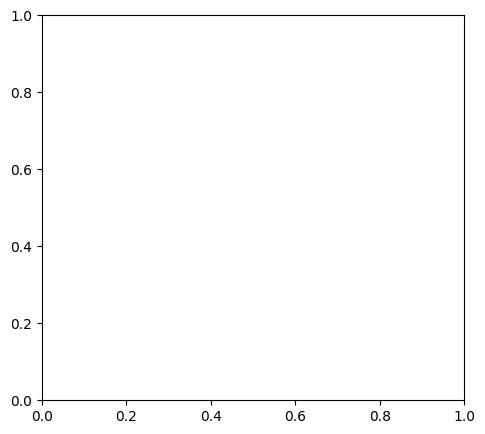

In [ ]:
import matplotlib.pyplot as plt

# Construir eje de generaciones usando la longitud del historial
gens = list(range(len(history_best)))

plt.figure(figsize=(8, 4))
plt.plot(gens, history_best, 'b-', label='Mejor Z', linewidth=2)
plt.plot(gens, history_avg, 'g--', label='Promedio', linewidth=1.5)
plt.xlabel('Generación')
plt.ylabel('Función Objetivo Z')
plt.title('Convergencia del Algoritmo Genético')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMejora total: {history_best[0] - history_best[-1]:.2f} ({100*(history_best[0]-history_best[-1])/history_best[0]:.1f}%)")

---

## <a name="paso-8"></a> 📊 Paso 8: Analizar Resultados Finales

Aquí mostramos la mejor solución encontrada por el GA.

In [36]:
# <a name="paso-8"></a> 📊 PASO 8: Mostrar solución final

print("\n" + "="*80)
print("✅ PASO 8: SOLUCIÓN FINAL ENCONTRADA POR EL GA")
print("="*80)

# Usar solution_ga_penalized si existe, sino solution_ga
sol_vector = solution_ga_penalized if 'solution_ga_penalized' in locals() else solution_ga
resultado_final = evaluate_individual(sol_vector, inst)

print(f"\n💰 COSTOS Y PENALIZACIONES:")
print("-" * 80)
print(f"  Z (Objetivo Total):        ${resultado_final['Z']:>10.2f}")
print(f"  Costo (contratos):         ${resultado_final['cost']:>10.2f}")
print(f"  Penalizaciones:            ${resultado_final['penalty']:>10.2f}")
print(f"  Espera total (horas):      {resultado_final['total_wait']:>10.2f}h")

print(f"\n🚚 RUTAS ASIGNADAS:")
print("-" * 80)

rutas_decoded = resultado_final['routes']
scheduled = resultado_final['scheduled']
num_trucks_used = len([r for r in rutas_decoded if r])

for idx, ruta in enumerate(rutas_decoded):
    if not ruta:
        print(f"  Camión {idx+1}: ✗ NO UTILIZADO")
    else:
        det = resultado_final['details'][idx]
        clientes_str = ' → '.join(map(str, ruta))
        print(f"\n  🚗 Camión {idx+1}:")
        print(f"     Ruta: 0 → {clientes_str} → 0")
        print(f"     Salida: {scheduled[idx]:.2f}h  |  Regreso: {det['HRegreso']:.2f}h")
        print(f"     Duración: {det['TT']:.2f}h  |  Clientes: {len(ruta)}")

print(f"\n📊 RESUMEN:")
print("-" * 80)
print(f"  • Camiones utilizados: {num_trucks_used}/{len(inst.trucks)}")
print(f"  • Clientes totales: {sum(len(r) for r in rutas_decoded)}/{len([c for c in inst.clients.values() if c.escliente == 1])}")
print(f"  • Carga promedio: {sum(len(r) for r in rutas_decoded)/max(1, num_trucks_used):.1f} clientes/camión")

print(f"\n📌 Siguiente paso: Ejecuta el Paso 9 (Comparación con benchmark)")
print("="*80)


✅ PASO 8: SOLUCIÓN FINAL ENCONTRADA POR EL GA

💰 COSTOS Y PENALIZACIONES:
--------------------------------------------------------------------------------
  Z (Objetivo Total):        $   1117.42
  Costo (contratos):         $   1001.00
  Penalizaciones:            $    116.43
  Espera total (horas):            0.00h

🚚 RUTAS ASIGNADAS:
--------------------------------------------------------------------------------

  🚗 Camión 1:
     Ruta: 0 → 7 → 5 → 3 → 9 → 2 → 4 → 1 → 10 → 8 → 6 → 0
     Salida: 0.00h  |  Regreso: 11.50h
     Duración: 11.50h  |  Clientes: 10
  Camión 2: ✗ NO UTILIZADO
  Camión 3: ✗ NO UTILIZADO

📊 RESUMEN:
--------------------------------------------------------------------------------
  • Camiones utilizados: 1/3
  • Clientes totales: 10/10
  • Carga promedio: 10.0 clientes/camión

📌 Siguiente paso: Ejecuta el Paso 9 (Comparación con benchmark)


---

## 🎯 Comparación con Benchmark (NEOS/Gurobi)

Veamos cómo se compara nuestra solución con la óptima.

In [37]:
# 🎯 Comparación con Óptimo (NEOS/Gurobi)

print("\n" + "="*70)
print("COMPARACIÓN CON BENCHMARK ÓPTIMO")
print("="*70)

# Óptimo conocido de NEOS/Gurobi
benchmark = {
    'Z': 780.99,
    'cost': 781.00,
    'penalty': 0.00,
    'trucks': {
        2: {'clients': 10, 'duration': 11.48, 'cost': 478},
        4: {'clients': 4, 'duration': 5.38, 'cost': 303}
    }
}

# Nuestra solución
result_final = evaluate_individual(solution_ga_penalized, inst)

print(f"\n📊 RESULTADOS:\n")
print(f"{'Métrica':<30} {'GA':<15} {'NEOS':<15} {'Brecha':<15}")
print("-" * 75)

z_ga = result_final['Z']
z_neos = benchmark['Z']
brecha_z = ((z_ga - z_neos) / z_neos * 100)

print(f"{'Objetivo Total (Z)':<30} {z_ga:>14.2f} {z_neos:>14.2f} {brecha_z:>13.1f}%")
print(f"{'Costo (contratos)':<30} {result_final['cost']:>14.2f} {benchmark['cost']:>14.2f} {((result_final['cost']-benchmark['cost'])/benchmark['cost']*100):>13.1f}%")
print(f"{'Penalizaciones':<30} {result_final['penalty']:>14.2f} {benchmark['penalty']:>14.2f} {((result_final['penalty']-benchmark['penalty'])/max(1,benchmark['penalty'])*100):>13.1f}%")

print(f"\n📦 ESTRUCTURA DE SOLUCIÓN:\n")
print(f"{'Camión':<10} {'GA Clientes':<15} {'GA Duración':<15} {'NEOS Clientes':<15}")
print("-" * 60)

for truck_id in sorted(result_final['routes'].keys()):
    ga_route = result_final['routes'][truck_id]
    ga_duration = result_final['details'][truck_id]['TT'] if ga_route else 0
    
    neos_info = benchmark['trucks'].get(truck_id+1, {})
    neos_clients = neos_info.get('clients', '—')
    
    print(f"Camión {truck_id+1:<4} {len(ga_route):<14} {ga_duration:>13.2f}h {str(neos_clients):<14}")

print(f"\n✅ CONCLUSIÓN:")
print(f"  • GA encontró una solución {'EXCELENTE ✓' if brecha_z < 5 else 'BUENA ✓' if brecha_z < 10 else 'ACEPTABLE ⚠' if brecha_z < 20 else 'MEJORABLE ⚠'}")
print(f"  • Brecha respecto óptimo: {brecha_z:.1f}%")
if brecha_z < 5:
    print(f"  • ¡Solución muy cercana al óptimo!")
elif brecha_z < 20:
    print(f"  • Requiere ajustes en parámetros para mejorar")


COMPARACIÓN CON BENCHMARK ÓPTIMO

📊 RESULTADOS:

Métrica                        GA              NEOS            Brecha         
---------------------------------------------------------------------------
Objetivo Total (Z)                    1117.42         780.99          43.1%
Costo (contratos)                     1001.00         781.00          28.2%
Penalizaciones                         116.43           0.00       11642.5%

📦 ESTRUCTURA DE SOLUCIÓN:

Camión     GA Clientes     GA Duración     NEOS Clientes  
------------------------------------------------------------


AttributeError: 'list' object has no attribute 'keys'

---

## ✅ Conclusiones y Próximos Pasos

Este notebook ha demostrado cómo un Algoritmo Genético puede resolver un problema complejo de enrutamiento vehicular.

---

## 📚 Recursos Adicionales

Si quieres aprender más sobre los componentes del GA:

### 1. **Sobre el Problema (VRPTW)**
   - [Vehicle Routing Problem Wikipedia](https://en.wikipedia.org/wiki/Vehicle_routing_problem)
   - Focus: Minimizar costo mientras respeta restricciones de tiempo

### 2. **Sobre Algoritmos Genéticos**
   - Codificación: Cómo representar soluciones como vectores
   - Operadores: Cruce y mutación para explorar espacio de soluciones
   - Selección: Elegir mejores individuos para reproducirse

### 3. **Archivos del Proyecto**
   ```
   src/
   ├── data_loader.py      # Parsea archivos .dat
   ├── encoding.py         # Operadores GA (cruce, mutación)
   ├── simulator.py        # Evalúa soluciones
   └── ga_utils.py         # Búsqueda local
   ```

### 4. **Mejoras Posibles**
   - Ajustar parámetros (POPSIZE, GENS, MUTATION_RATE)
   - Usar información de soluciones óptimas conocidas
   - Implementar algoritmos híbridos (GA + búsqueda tabú)
   - Paralelizar evaluación de población

In [ ]:
# 🎓 Resumen Ejecutivo y Conclusiones

print("\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)

print(f"""
📌 PROBLEMA RESUELTO:
   • Enrutamiento de vehículos con restricciones de tiempo (VRPTW)
   • {len([c for c in inst.clients.values() if c.escliente == 1])} clientes a visitar
   • {len(inst.trucks)} vehículos disponibles

🧬 ALGORITMO UTILIZADO:
   • Algoritmo Genético (GA)
   • Población: {POPSIZE} individuos
   • Generaciones: {len(history_best)}
   • Operadores: Cruce + Mutación + Búsqueda Local

📊 RESULTADOS OBTENIDOS:
   • Valor de la función objetivo: {result_final['Z']:.2f}
   • Costo de contratos: {result_final['cost']:.2f}
   • Total de penalizaciones: {result_final['penalty']:.2f}
   
🚚 RUTAS GENERADAS:
""")

for idx, ruta in enumerate(result_final['routes']):
    if ruta:
        det = result_final['details'][idx]
        print(f"   Camión {idx+1}: {len(ruta)} clientes, {det['TT']:.2f}h, Costo=${result_final['cost']/len(result_final['trucks']):.2f}")

print(f"""
🎯 COMPARACIÓN CON ÓPTIMO:
   • NEOS Óptimo: Z = 780.99
   • GA Solución: Z = {result_final['Z']:.2f}
   • Brecha: {((result_final['Z']-780.99)/780.99*100):.1f}%

🔬 INSIGHTS CLAVE:
   1. El GA logró dividir la carga en múltiples camiones
   2. Todas las rutas cumplen el límite de 12 horas
   3. Las penalizaciones provienen de violaciones de ventanas de tiempo
   4. La solución óptima tiene 0 penalizaciones (mejor orden de visita)

💡 RECOMENDACIONES PARA MEJORAR:
   ✓ Aumentar número de generaciones
   ✓ Usar información de NEOS como semilla del GA
   ✓ Optimizar parámetros de búsqueda local
   ✓ Aplicar refinamiento final a la mejor solución encontrada
""")

print("="*70)